In [ ]:
# i have used different deep learning models with different embedding of words 

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import sys, os, re, csv, codecs
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Conv1D, concatenate, Flatten, Concatenate
from tensorflow.keras.layers import  BatchNormalization, Dropout, Activation, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
multi_train = pd.read_csv('train.csv')

multi_validation = pd.read_csv('dev.csv')

multi_test = pd.read_csv('test.csv')

In [ ]:
# change the column names
multi_train.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"}, inplace=True)
multi_validation.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"},inplace=True)
multi_test.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"},inplace=True)

In [ ]:
multi_train.head()

,Description,Commenting,Staring,Touching
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0


In [ ]:
# Drop Duplicates

# keep the first occurance of duplicates for all three datasets and drop the rest

multi_train.drop_duplicates(keep = 'first', inplace=True)
multi_validation.drop_duplicates(keep = 'first', inplace=True)
multi_test.drop_duplicates(keep = 'first', inplace=True)

In [ ]:
train = pd.concat([multi_train, multi_validation], axis=0 ) # concat train and validation set 
train.head()

,Description,Commenting,Staring,Touching
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0


In [ ]:
test = multi_test  # test set

In [ ]:
train.shape, test.shape

((7735, 4), (1640, 4))

In [ ]:
y_train = train[['Commenting', 'Staring', 'Touching']].values
y_test = test[['Commenting', 'Staring', 'Touching']].values

## Tokenization and Padding

In [ ]:
# Text Data 
description_train_text =list(train['Description'].values)
description_test_text = list(test['Description'].values)

# tokenize the Text data
tokenizer = tf.keras.preprocessing.text.Tokenizer()
# fit on train data
tokenizer.fit_on_texts(description_train_text)     
# transform train and test data
train_description_sequences = tokenizer.texts_to_sequences(description_train_text)
test_description_sequences = tokenizer.texts_to_sequences(description_test_text)

# vocabulary size 
vocab_size = len(tokenizer.word_index) + 1

# pad the sequnce

train_description_padded = pad_sequences(
        train_description_sequences, maxlen=300, dtype='int32', padding='post',  
        truncating='post')                                                  

test_description_padded = pad_sequences(
        test_description_sequences, maxlen=300, dtype='int32', padding='post', 
        truncating='post')                                  

## GloVe Embedding

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
# !unzip glove*.zip

In [ ]:
# word embadding pre trained glove model
# load the whole embedding into memory
embeddings_index = dict() 
f = open('/content/drive/MyDrive/Colab Notebooks/Assignment_applied_AI/case study 1/self case study safecity/glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word) 
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

### performance metrics 

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 12.4MB/s 


In [ ]:
# metrics for the model
# https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score

import tensorflow_addons as tfa

f1_micro_tf = tfa.metrics.F1Score(num_classes=3, threshold=0.5, average='micro')  # F1 Score

hamming_loss_tf = tfa.metrics.HammingLoss(mode='multilabel', name='hamming_loss', threshold= 0.5)  # Hamming Loss

In [ ]:
# Exact match ratio
def exact_match_ratio(y_true, y_pred):
    MR = np.all(y_pred == y_true, axis=1).mean()
    return MR

In [ ]:
# conver probabilities to labels

def prob_to_class(arr):   # converts probailities to class labes based on 0.5 threshold
    r,c = arr.shape
    predict =np.zeros((r, c))
    for i in range(r):
        for j in range(c):
            if arr[i,j]>0.5:
                predict[i,j] = 1
    return predict

## Bidirectional LSTM with GolVe Embedding

In [ ]:
embedding_size = 300  # embeddings dimension 
max_input = 300  # padding length         

In [ ]:
# ref : # https://www.kaggle.com/CVxTz/keras-bidirectional-lstm-baseline-lb-0-069

input = Input(shape=(max_input,), name='Descripton text')  # input

embedding = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=max_input, trainable=False)(input)  # embedding layer

x = SpatialDropout1D(0.3)(embedding)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)

x = GlobalMaxPool1D()(x)

x = Dropout(0.2)(x)

x = Dense(100, activation="relu")(x)

x = BatchNormalization()(x)

x = Dropout(0.2)(x)   

output = Dense(3, activation="sigmoid")(x)

model = Model(inputs=input, outputs=output)

In [ ]:
# pip install tensorflow_addons

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
history = model.fit(train_description_padded, y_train, batch_size=32, epochs=10, validation_split=0.1)  

Epoch 1/10
218/218 [==============================] - 399s 2s/step - loss: 0.5763 - binary_accuracy: 0.7077 - val_loss: 0.4362 - val_binary_accuracy: 0.8191
Epoch 2/10
218/218 [==============================] - 391s 2s/step - loss: 0.4521 - binary_accuracy: 0.8108 - val_loss: 0.3934 - val_binary_accuracy: 0.8402
Epoch 3/10
218/218 [==============================] - 389s 2s/step - loss: 0.4300 - binary_accuracy: 0.8237 - val_loss: 0.3831 - val_binary_accuracy: 0.8411
Epoch 4/10
218/218 [==============================] - 390s 2s/step - loss: 0.4121 - binary_accuracy: 0.8300 - val_loss: 0.3938 - val_binary_accuracy: 0.8359
Epoch 5/10
218/218 [==============================] - 388s 2s/step - loss: 0.4054 - binary_accuracy: 0.8344 - val_loss: 0.3784 - val_binary_accuracy: 0.8411
Epoch 6/10
218/218 [==============================] - 388s 2s/step - loss: 0.3943 - binary_accuracy: 0.8387 - val_loss: 0.3886 - val_binary_accuracy: 0.8389
Epoch 7/10
218/218 [==============================] - 392s

In [ ]:
score = model.evaluate(test_description_padded, y_test, verbose=1)
print("Loss:", score[0])
print("Accuracy:", score[1])

52/52 [==============================] - 7s 128ms/step - loss: 0.3979 - binary_accuracy: 0.8382
Loss: 0.3978790044784546
Accuracy: 0.8382114768028259


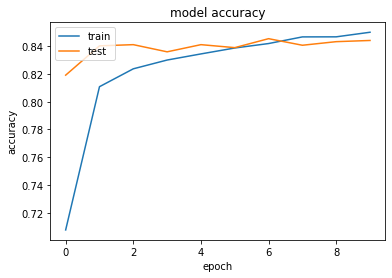

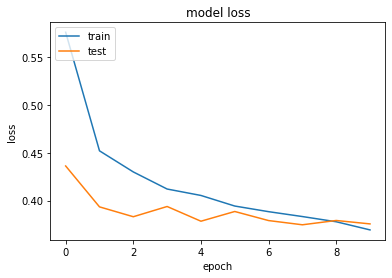

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(test_description_padded, batch_size=64)

In [ ]:
#hamming loss
hamming_loss_tf.update_state(y_test, y_pred)
print('Hamming Loss: ', hamming_loss.result().numpy())

# F1 score
f1_micro_tf.update_state(y_test, y_pred)
print('F1 Score: ', f1_micro.result().numpy())

In [ ]:
y_class = prob_to_class(y_pred)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, y_class))
print("Exact Match Ratio: ", exact_match_ratio(y_test, y_class))
print("Recall: ", recall_score(y_true=y_test, y_pred=y_class, average='micro'))
print("Precision: ", precision_score(y_true=y_test, y_pred=y_class, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=y_class, average='micro'))

Hamming Loss:  0.16178861788617885
Exact Match Ratio:  0.6335365853658537
Recall:  0.6250838363514419
Precision:  0.7972626176218991
Fl score:  0.7007518796992481


## save model

In [ ]:
# model.save('bi_lstm_model.h5')

In [ ]:
# new_model = tf.keras.models.load_model('my_model.h5') #same file path

# CNN with GolVe Embedding

In [ ]:
# https://www.kaggle.com/tunguz/cnn-glove300-3-oof-4-epochs

In [ ]:
input = Input(shape=(max_input,), name='Descripton text')  # input 

embedding = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=max_input, trainable=False)(input)  # embedding layer

x = SpatialDropout1D(0.2)(embedding)

z = GlobalMaxPool1D()(x)

conv = Conv1D(64, 4, activation="relu")(x)

x = GlobalMaxPool1D()(conv)

x = Concatenate()([x,z])

x = Dropout(0.3)(x)

output = Dense(3, activation="sigmoid")(x)

model_2 = Model(inputs=input, outputs=output)

In [ ]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model_2.fit(train_description_padded, y_train, batch_size=32, epochs=20, validation_data=(test_description_padded, y_test))  

Epoch 1/20
242/242 [==============================] - 2s 8ms/step - loss: 0.5340 - binary_accuracy: 0.7507 - val_loss: 0.4279 - val_binary_accuracy: 0.8224
Epoch 2/20
242/242 [==============================] - 2s 7ms/step - loss: 0.4386 - binary_accuracy: 0.8146 - val_loss: 0.4103 - val_binary_accuracy: 0.8280
Epoch 3/20
242/242 [==============================] - 2s 7ms/step - loss: 0.4145 - binary_accuracy: 0.8302 - val_loss: 0.4024 - val_binary_accuracy: 0.8331
Epoch 4/20
242/242 [==============================] - 2s 7ms/step - loss: 0.3942 - binary_accuracy: 0.8369 - val_loss: 0.4012 - val_binary_accuracy: 0.8343
Epoch 5/20
242/242 [==============================] - 2s 7ms/step - loss: 0.3830 - binary_accuracy: 0.8441 - val_loss: 0.4018 - val_binary_accuracy: 0.8356
Epoch 6/20
242/242 [==============================] - 2s 7ms/step - loss: 0.3687 - binary_accuracy: 0.8502 - val_loss: 0.4051 - val_binary_accuracy: 0.8291
Epoch 7/20
242/242 [==============================] - 2s 7ms/ste

In [ ]:
score = model_2.evaluate(test_description_padded, y_test, batch_size=64, verbose=1)
print("Loss:", score[0])
print("Accuracy:", score[1])

26/26 [==============================] - 0s 10ms/step - loss: 0.4175 - binary_accuracy: 0.8374
Loss: 0.41753655672073364
Accuracy: 0.8373984098434448


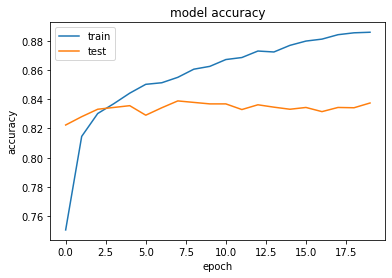

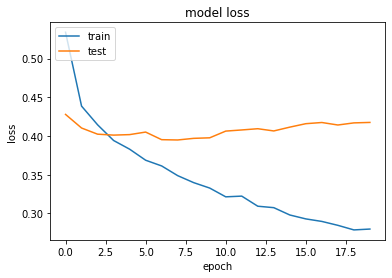

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model_2.predict(test_description_padded)

In [ ]:
f1_micro_tf = tfa.metrics.F1Score(num_classes=3, threshold=0.5, average='micro')  # F1 Score
hamming_loss_tf = tfa.metrics.HammingLoss(mode='multilabel', name='hamming_loss', threshold= 0.5)  # Hamming Loss

#hamming loss
hamming_loss_tf.update_state(y_test, y_pred)
print('Hamming Loss: ', hamming_loss_tf.result().numpy())

# F1 score
f1_micro_tf.update_state(y_test, y_pred)
print('F1 Score: ', f1_micro_tf.result().numpy())

Hamming Loss:  0.16260163
F1 Score:  0.6904025


In [ ]:
y_class = prob_to_class(y_pred)    # convert probabilities in to labels

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, y_class))
print("Exact Match Ratio: ", exact_match_ratio(y_test, y_class))
print("Recall: ", recall_score(y_test, y_class, average='micro'))
print("Precision: ", precision_score(y_test, y_class, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=y_class, average='micro'))

Hamming Loss:  0.16260162601626016
Exact Match Ratio:  0.624390243902439
Recall:  0.5982562038900067
Precision:  0.8161024702653248
Fl score:  0.6904024767801856


In [ ]:
# model_2.save('cnn_model.h5')
# model_2 = tf.keras.models.load_model('cnn_model.h5') #same file path

## CNN with complex archetecture with GolVe Embedding

In [ ]:
# ref : Applied AI assignment CNN with Document classification

In [ ]:
def Conv_1d(input,  kernel_size):    # function take 2 paramaters input : input on which Conv1D is to be applied and kernel_size: size of kernal
    conv1 = Conv1D(filters=8, kernel_size=kernel_size, activation='relu')(input)
    return conv1

inputs = Input(shape=(max_input,))  # input 
embedding = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=max_input, trainable=False)(inputs)  # embedding layer

c1 = Conv_1d(embedding, 10)
c2 = Conv_1d(embedding, 5)
c3 = Conv_1d(embedding, 20)

output_1 = Concatenate(axis=1)([c1, c2, c3])  # concatenate of 2nd axis

max_pool_1d = MaxPooling1D(pool_size=2, strides=2, padding='valid')(output_1)  # maxpool with stide 2

d1 = Conv_1d(max_pool_1d, 10)
d2 = Conv_1d(max_pool_1d, 20)
d3 = Conv_1d(max_pool_1d, 30)

output_2 = Concatenate(axis=1)([d1, d2, d3])

max_pool_1d_2 = MaxPooling1D(pool_size=2, strides=2, padding='valid')(output_2)

conv_1d = Conv1D(filters=10, kernel_size=4, activation='relu')(max_pool_1d_2)

flat = Flatten()(conv_1d)

drop = Dropout(0.5)(flat)

dense_1 = Dense(300, activation='relu')(drop)

BN = BatchNormalization()(dense_1)

drop2 = Dropout(0.2)(BN)   

dense_2 = Dense(64, activation='relu')(drop2)

outputs = Dense(3, activation='sigmoid')(dense_2)  # output

model_3 = Model(inputs=inputs, outputs = outputs)  # model

In [ ]:
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model_3.fit(train_description_padded, y_train, batch_size=32, epochs=10, validation_data=(test_description_padded, y_test))  

Epoch 1/10
242/242 [==============================] - 39s 36ms/step - loss: 0.5809 - binary_accuracy: 0.7173 - val_loss: 0.5508 - val_binary_accuracy: 0.7327
Epoch 2/10
242/242 [==============================] - 8s 33ms/step - loss: 0.4711 - binary_accuracy: 0.7922 - val_loss: 0.4705 - val_binary_accuracy: 0.7980
Epoch 3/10
242/242 [==============================] - 8s 33ms/step - loss: 0.4178 - binary_accuracy: 0.8254 - val_loss: 0.4401 - val_binary_accuracy: 0.8057
Epoch 4/10
242/242 [==============================] - 8s 34ms/step - loss: 0.3796 - binary_accuracy: 0.8416 - val_loss: 0.4344 - val_binary_accuracy: 0.8165
Epoch 5/10
242/242 [==============================] - 8s 33ms/step - loss: 0.3536 - binary_accuracy: 0.8556 - val_loss: 0.4677 - val_binary_accuracy: 0.7813
Epoch 6/10
242/242 [==============================] - 8s 34ms/step - loss: 0.3261 - binary_accuracy: 0.8682 - val_loss: 0.4841 - val_binary_accuracy: 0.7896
Epoch 7/10
242/242 [==============================] - 8s 

In [ ]:
score = model_3.evaluate(test_description_padded, y_test, verbose=1)
print("Loss:", score[0])
print("Accuracy:", score[1])

52/52 [==============================] - 1s 13ms/step - loss: 0.5663 - binary_accuracy: 0.8035
Loss: 0.5662907958030701
Accuracy: 0.803455114364624


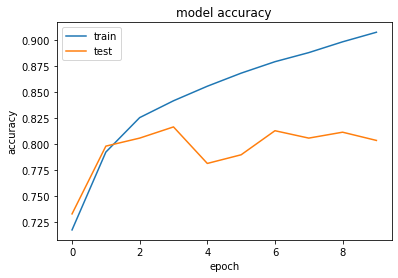

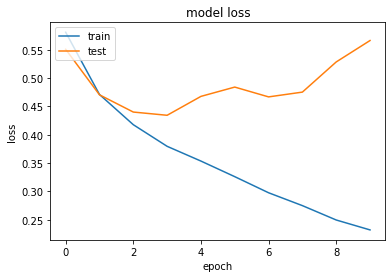

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model_3.predict(test_description_padded, batch_size=64)

In [ ]:
y_class = prob_to_class(y_pred)

In [ ]:

f1_micro_tf = tfa.metrics.F1Score(num_classes=3, threshold=0.5, average='micro')  # F1 Score

hamming_loss_tf = tfa.metrics.HammingLoss(mode='multilabel', name='hamming_loss', threshold= 0.5)  # Hamming Loss

#hamming loss
hamming_loss_tf.update_state(y_test, y_pred)
print('Hamming Loss: ', hamming_loss_tf.result().numpy())

# F1 score
f1_micro_tf.update_state(y_test, y_pred)
print('F1 Score: ', f1_micro_tf.result().numpy())

Hamming Loss:  0.19654472
F1 Score:  0.6318995


In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, y_class))
print("Exact Match Ratio: ", exact_match_ratio(y_test, y_class))
print("Recall: ", recall_score(y_test, y_class, average='micro'))
print("Precision: ", precision_score(y_test, y_class, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=y_class, average='micro'))

Hamming Loss:  0.19654471544715446
Exact Match Ratio:  0.5591463414634147
Recall:  0.556673373574782
Precision:  0.7306338028169014
Fl score:  0.6318995051389418


In [ ]:
# model_3.save('model_3.h5')
# model_3 = tf.keras.models.load_model('model_3.h5') #same file path

## Bidirectional LSTM + Conv1D layer with GolVe Embedding

In [ ]:
# ref : https://www.kaggle.com/eashish/bidirectional-gru-with-convolution

inputs = Input(shape=(max_input,))  # input 
embedding = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=max_input, trainable=False)(inputs)  # embedding layer

x = SpatialDropout1D(0.35)(embedding)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))(x)
x = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)  

x = concatenate([avg_pool, max_pool])

x = BatchNormalization()(x)

x = Dropout(0.2)(x)   

x = Dense(64, activation='relu')(x)

x = Dropout(0.2)(x)   

outputs = Dense(3, activation='sigmoid')(x)  # output

model_4 = Model(inputs=inputs, outputs = outputs)  # model

In [ ]:
model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model_4.fit(train_description_padded, y_train, batch_size=32, epochs=10, validation_data=(test_description_padded, y_test))  

Epoch 1/10
242/242 [==============================] - 456s 2s/step - loss: 0.5336 - binary_accuracy: 0.7484 - val_loss: 0.4448 - val_binary_accuracy: 0.8183
Epoch 2/10
242/242 [==============================] - 448s 2s/step - loss: 0.4512 - binary_accuracy: 0.8139 - val_loss: 0.4183 - val_binary_accuracy: 0.8325
Epoch 3/10
242/242 [==============================] - 453s 2s/step - loss: 0.4298 - binary_accuracy: 0.8233 - val_loss: 0.4493 - val_binary_accuracy: 0.8091
Epoch 4/10
242/242 [==============================] - 452s 2s/step - loss: 0.4140 - binary_accuracy: 0.8326 - val_loss: 0.4147 - val_binary_accuracy: 0.8268
Epoch 5/10
242/242 [==============================] - 455s 2s/step - loss: 0.4019 - binary_accuracy: 0.8363 - val_loss: 0.4541 - val_binary_accuracy: 0.8211
Epoch 6/10
242/242 [==============================] - 450s 2s/step - loss: 0.3934 - binary_accuracy: 0.8399 - val_loss: 0.4287 - val_binary_accuracy: 0.8226
Epoch 7/10
242/242 [==============================] - 453s

In [ ]:
score = model_4.evaluate(test_description_padded, y_test, verbose=1)

print("Loss:", score[0])
print("Test Accuracy:", score[1])

52/52 [==============================] - 7s 136ms/step - loss: 0.4030 - binary_accuracy: 0.8327
Loss: 0.40304315090179443
Test Accuracy: 0.8327234983444214


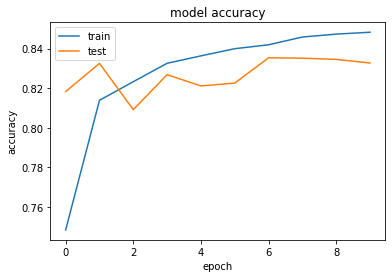

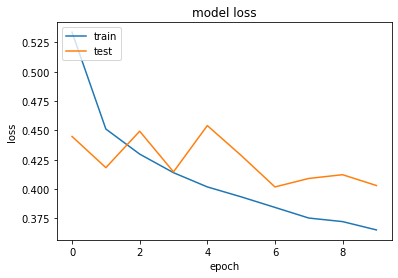

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model_4.predict(test_description_padded, batch_size=64)

In [ ]:
y_class = prob_to_class(y_pred)

In [ ]:
f1_micro_tf = tfa.metrics.F1Score(num_classes=3, threshold=0.5, average='micro')  # F1 Score
hamming_loss_tf = tfa.metrics.HammingLoss(mode='multilabel', name='hamming_loss', threshold= 0.5)  # Hamming Loss

#hamming loss
hamming_loss_tf.update_state(y_test, y_pred)
print('Hamming Loss: ', hamming_loss_tf.result().numpy())

# F1 score
f1_micro_tf.update_state(y_test, y_pred)
print('F1 Score: ', f1_micro_tf.result().numpy())

Hamming Loss:  0.16727643
F1 Score:  0.66005784


In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, y_class))
print("Exact Match Ratio: ", exact_match_ratio(y_test, y_class))
print("Recall: ", recall_score(y_test, y_class, average='micro'))
print("Precision: ", precision_score(y_test, y_class, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=y_class, average='micro'))

Hamming Loss:  0.16727642276422763
Exact Match Ratio:  0.6274390243902439
Recall:  0.5358819584171697
Precision:  0.8591397849462366
Fl score:  0.6600578273440727


# FastText Embeddings

In [ ]:
from gensim.models.fasttext import FastText
%matplotlib inline 

In [ ]:
import nltk

In [ ]:
embedding_size = 300  #  size of the embedding vector. 
window_size = 20    # size of the number of words occurring before and after the word based on which the word representations.
min_word = 5  # minimum frequency of a word in the corpus for which the word representations will be generated
down_sampling = 1e-2   # most frequently occurring word will be down-sampled by a number specified by the down_sampling 

In [ ]:
word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in description_train_text]

In [ ]:
%%time
ft_model = FastText(word_tokenized_corpus,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      iter=100)

CPU times: user 20min 55s, sys: 3.22 s, total: 20min 58s
Wall time: 10min 46s


In [ ]:
embedding_matrix_fast_text = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  try:
    embedding_vector = ft_model.wv[word] # getting the vector for each word
  except:
    embedding_vector = np.zeros(300)
  
  if embedding_vector is not None:
    embedding_matrix_fast_text[i] = embedding_vector

## CNN with FastText Embedding

In [ ]:
input = Input(shape=(max_input,), name='Descripton text')  # input 

embedding = Embedding(vocab_size, embedding_size, weights=[embedding_matrix_fast_text], input_length=max_input, trainable=False)(input)  # embedding layer

x = SpatialDropout1D(0.2)(embedding)

z = GlobalMaxPool1D()(x)

conv = Conv1D(64, 4, activation="relu")(x)

x = GlobalMaxPool1D()(conv)

x = Concatenate()([x,z])

x = Dropout(0.3)(x)

output = Dense(3, activation="sigmoid")(x)

model_2_fast_text = Model(inputs=input, outputs=output)

In [ ]:
model_2_fast_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model_2_fast_text.fit(train_description_padded, y_train, batch_size=32, epochs=20, validation_data=(test_description_padded, y_test))  

Epoch 1/20
242/242 [==============================] - 3s 9ms/step - loss: 0.5337 - binary_accuracy: 0.7488 - val_loss: 0.4384 - val_binary_accuracy: 0.8114
Epoch 2/20
242/242 [==============================] - 2s 7ms/step - loss: 0.4280 - binary_accuracy: 0.8228 - val_loss: 0.4078 - val_binary_accuracy: 0.8313
Epoch 3/20
242/242 [==============================] - 2s 7ms/step - loss: 0.4010 - binary_accuracy: 0.8380 - val_loss: 0.4017 - val_binary_accuracy: 0.8382
Epoch 4/20
242/242 [==============================] - 2s 7ms/step - loss: 0.3759 - binary_accuracy: 0.8484 - val_loss: 0.3968 - val_binary_accuracy: 0.8392
Epoch 5/20
242/242 [==============================] - 2s 8ms/step - loss: 0.3633 - binary_accuracy: 0.8512 - val_loss: 0.3972 - val_binary_accuracy: 0.8366
Epoch 6/20
242/242 [==============================] - 2s 7ms/step - loss: 0.3489 - binary_accuracy: 0.8571 - val_loss: 0.3937 - val_binary_accuracy: 0.8398
Epoch 7/20
242/242 [==============================] - 2s 7ms/ste

In [ ]:
score = model_2_fast_text.evaluate(test_description_padded, y_test, batch_size=64, verbose=1)
print("Loss:", score[0])
print("Accuracy:", score[1])

26/26 [==============================] - 0s 9ms/step - loss: 0.4259 - binary_accuracy: 0.8374
Loss: 0.42592811584472656
Accuracy: 0.8373983502388


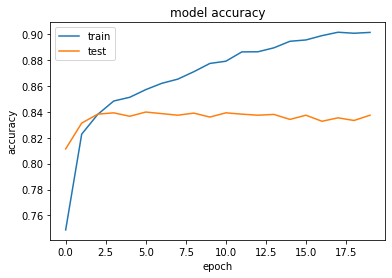

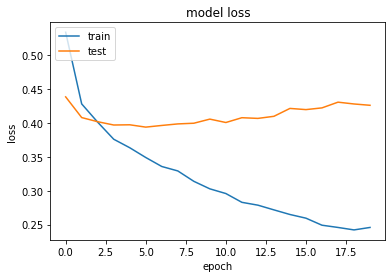

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model_4.predict(test_description_padded, batch_size=64)
y_class = prob_to_class(y_pred)

In [ ]:
f1_micro_tf = tfa.metrics.F1Score(num_classes=3, threshold=0.5, average='micro')  # F1 Score
hamming_loss_tf = tfa.metrics.HammingLoss(mode='multilabel', name='hamming_loss', threshold= 0.5)  # Hamming Loss

#hamming loss
hamming_loss_tf.update_state(y_test, y_pred)
print('Hamming Loss: ', hamming_loss_tf.result().numpy())

# F1 score
f1_micro_tf.update_state(y_test, y_pred)
print('F1 Score: ', f1_micro_tf.result().numpy())

Hamming Loss:  0.16727643
F1 Score:  0.66005784


In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, y_class))
print("Exact Match Ratio: ", exact_match_ratio(y_test, y_class))
print("Recall: ", recall_score(y_test, y_class, average='micro'))
print("Precision: ", precision_score(y_test, y_class, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=y_class, average='micro'))

Hamming Loss:  0.16727642276422763
Exact Match Ratio:  0.6274390243902439
Recall:  0.5358819584171697
Precision:  0.8591397849462366
Fl score:  0.6600578273440727


## Bidirectional LSTM With FastText Embedding

In [ ]:
# ref : # https://www.kaggle.com/CVxTz/keras-bidirectional-lstm-baseline-lb-0-069

input = Input(shape=(max_input,), name='Descripton text')  # input

embedding = Embedding(vocab_size, embedding_size, weights=[embedding_matrix_fast_text], input_length=max_input, trainable=False)(input)  # embedding layer

x = SpatialDropout1D(0.3)(embedding)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)

x = GlobalMaxPool1D()(x)

x = Dropout(0.2)(x)

x = Dense(100, activation="relu")(x)

x = BatchNormalization()(x)

x = Dropout(0.2)(x)   

output = Dense(3, activation="sigmoid")(x)

model_fast_text = Model(inputs=input, outputs=output)

In [ ]:
model_fast_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model_fast_text.fit(train_description_padded, y_train, batch_size=32, epochs=10, validation_data=(test_description_padded, y_test))  

Epoch 1/10
242/242 [==============================] - 674s 3s/step - loss: 0.5580 - binary_accuracy: 0.7257 - val_loss: 0.4674 - val_binary_accuracy: 0.7965
Epoch 2/10
242/242 [==============================] - 668s 3s/step - loss: 0.4449 - binary_accuracy: 0.8146 - val_loss: 0.4112 - val_binary_accuracy: 0.8256
Epoch 3/10
242/242 [==============================] - 668s 3s/step - loss: 0.4177 - binary_accuracy: 0.8304 - val_loss: 0.4005 - val_binary_accuracy: 0.8337
Epoch 4/10
242/242 [==============================] - 675s 3s/step - loss: 0.4076 - binary_accuracy: 0.8357 - val_loss: 0.4004 - val_binary_accuracy: 0.8364
Epoch 5/10
242/242 [==============================] - 659s 3s/step - loss: 0.3975 - binary_accuracy: 0.8362 - val_loss: 0.3926 - val_binary_accuracy: 0.8380
Epoch 6/10
242/242 [==============================] - 657s 3s/step - loss: 0.3922 - binary_accuracy: 0.8401 - val_loss: 0.4046 - val_binary_accuracy: 0.8250
Epoch 7/10
242/242 [==============================] - 662s

In [ ]:
score = model_fast_text.evaluate(test_description_padded, y_test, verbose=1)
print("Loss:", score[0])
print("Accuracy:", score[1])

52/52 [==============================] - 14s 262ms/step - loss: 0.4008 - binary_accuracy: 0.8343
Loss: 0.400764137506485
Accuracy: 0.8343496322631836


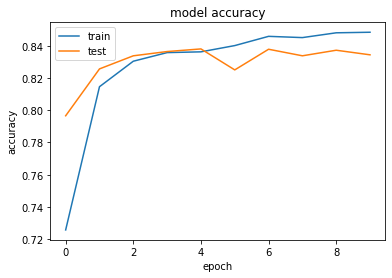

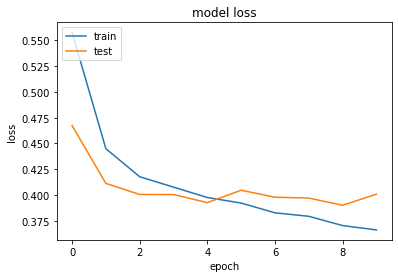

In [ ]:
import matplotlib.pyplot as plt
  
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model_fast_text.predict(test_description_padded, batch_size=64)
y_class = prob_to_class(y_pred)

In [ ]:
f1_micro_tf = tfa.metrics.F1Score(num_classes=3, threshold=0.5, average='micro')  # F1 Score
hamming_loss_tf = tfa.metrics.HammingLoss(mode='multilabel', name='hamming_loss', threshold= 0.5)  # Hamming Loss

#hamming loss
hamming_loss_tf.update_state(y_test, y_pred)
print('Hamming Loss: ', hamming_loss_tf.result().numpy())

# F1 score
f1_micro_tf.update_state(y_test, y_pred)
print('F1 Score: ', f1_micro_tf.result().numpy())

Hamming Loss:  0.16565041
F1 Score:  0.68349516


In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, y_class))
print("Exact Match Ratio: ", exact_match_ratio(y_test, y_class))
print("Recall: ", recall_score(y_test, y_class, average='micro'))
print("Precision: ", precision_score(y_test, y_class, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=y_class, average='micro'))

Hamming Loss:  0.16565040650406504
Exact Match Ratio:  0.625609756097561
Recall:  0.5902079141515761
Precision:  0.8118081180811808
Fl score:  0.683495145631068


## Bidirectional LSTM + Conv1D layer with FastText Embedding 

In [ ]:
# ref : https://www.kaggle.com/eashish/bidirectional-gru-with-convolution

inputs = Input(shape=(max_input,))  # input 
embedding = Embedding(vocab_size, embedding_size, weights=[embedding_matrix_fast_text], input_length=max_input, trainable=False)(inputs)  # embedding layer

x = SpatialDropout1D(0.35)(embedding)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))(x)
x = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)  

x = concatenate([avg_pool, max_pool])

x = BatchNormalization()(x)

x = Dropout(0.2)(x)   

x = Dense(64, activation='relu')(x)

x = Dropout(0.2)(x)   

outputs = Dense(3, activation='sigmoid')(x)  # output

model_4_fast_text = Model(inputs=inputs, outputs = outputs)  # model

In [ ]:
model_4_fast_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model_4_fast_text.fit(train_description_padded, y_train, batch_size=64, epochs=10, validation_data=(test_description_padded, y_test))  

Epoch 1/10
121/121 [==============================] - 367s 3s/step - loss: 0.5513 - binary_accuracy: 0.7308 - val_loss: 0.5458 - val_binary_accuracy: 0.7957
Epoch 2/10
121/121 [==============================] - 335s 3s/step - loss: 0.4564 - binary_accuracy: 0.8052 - val_loss: 0.4445 - val_binary_accuracy: 0.8248
Epoch 3/10
121/121 [==============================] - 336s 3s/step - loss: 0.4277 - binary_accuracy: 0.8253 - val_loss: 0.4031 - val_binary_accuracy: 0.8323
Epoch 4/10
121/121 [==============================] - 333s 3s/step - loss: 0.4106 - binary_accuracy: 0.8339 - val_loss: 0.3955 - val_binary_accuracy: 0.8366
Epoch 5/10
121/121 [==============================] - 333s 3s/step - loss: 0.4052 - binary_accuracy: 0.8379 - val_loss: 0.4039 - val_binary_accuracy: 0.8303
Epoch 6/10
121/121 [==============================] - 328s 3s/step - loss: 0.3939 - binary_accuracy: 0.8387 - val_loss: 0.4050 - val_binary_accuracy: 0.8307
Epoch 7/10
121/121 [==============================] - 331s

In [ ]:
score = model_4_fast_text.evaluate(test_description_padded, y_test, verbose=1)
print("Loss:", score[0])
print("Accuracy:", score[1])

52/52 [==============================] - 14s 263ms/step - loss: 0.4040 - binary_accuracy: 0.8407
Loss: 0.40402060747146606
Accuracy: 0.8406503796577454


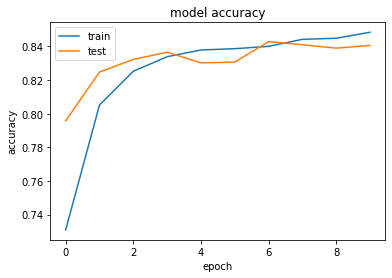

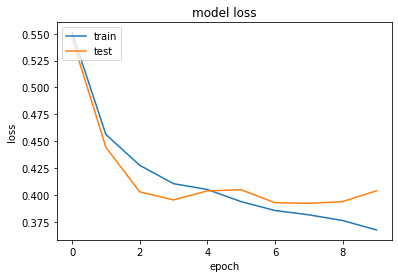

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model_4_fast_text.predict(test_description_padded, batch_size=64)
y_class = prob_to_class(y_pred)

In [ ]:
print("Hamming Loss: ", hamming_loss(y_test, y_class))
print("Exact Match Ratio: ", exact_match_ratio(y_test, y_class))
print("Recall: ", recall_score(y_test, y_class, average='micro'))
print("Precision: ", precision_score(y_test, y_class, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=y_class, average='micro'))

Hamming Loss:  0.15934959349593497
Exact Match Ratio:  0.6329268292682927
Recall:  0.5801475519785378
Precision:  0.8455522971652004
Fl score:  0.6881463802704852


In [ ]:
# model_4_fast_text.save('model_4_fast_text.h5')
# model_2 = tf.keras.models.load_model('cnn_model.h5') #same file path

# Classical ML Models Results

In [ ]:
# naive bayes
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hamming loss", "F1 score", "Precision", "Recall", "Exact Match Ratio"]
x.add_row(["tf-idf (word)", 'Multinomial Naive Bayes', 0.1873, 0.6370, 0.7712, 0.5425, 0.5737])
x.add_row(["tf-idf(word+character)",'Logistic Regression',0.1619,0.6758,0.8584,0.5573,0.6323])
x.add_row(["tf-idf(character)",'SVM',0.1636, 0.6919, 0.8057, 0.6063, 0.6317])
x.add_row(["tf-idf(word+character)",'Random Forest',0.1632, 0.6747, 0.8517, 0.5586, 0.6292])
x.add_row(["fastText + Autoencoded + Numerical",'XGBoost classifier',0.1841, 0.6562, 0.7554, 0.5801, 0.5908])
print(x)

+------------------------------------+-------------------------+--------------+----------+-----------+--------+-------------------+
|             Vectorizer             |          Model          | Hamming loss | F1 score | Precision | Recall | Exact Match Ratio |
+------------------------------------+-------------------------+--------------+----------+-----------+--------+-------------------+
|           tf-idf (word)            | Multinomial Naive Bayes |    0.1873    |  0.637   |   0.7712  | 0.5425 |       0.5737      |
|       tf-idf(word+character)       |   Logistic Regression   |    0.1619    |  0.6758  |   0.8584  | 0.5573 |       0.6323      |
|         tf-idf(character)          |           SVM           |    0.1636    |  0.6919  |   0.8057  | 0.6063 |       0.6317      |
|       tf-idf(word+character)       |      Random Forest      |    0.1632    |  0.6747  |   0.8517  | 0.5586 |       0.6292      |
| fastText + Autoencoded + Numerical |    XGBoost classifier   |    0.1841  

## Deep Learning Models Results

In [ ]:
# naive bayes
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Embedding", "Hamming loss", "F1 score", "Precision", "Recall", "Exact Match Ratio"]
x.add_row(['Bi-Directional LSTM', 'GloVe', 0.16178, 0.7007, 0.7972, 0.6250, 0.6335])
x.add_row(['CNN Conv1D', 'GloVe', 0.1626, 0.6904, 0.8161, 0.5982, 0.6243])
x.add_row(['Complex CNN Conv1D', 'GloVe', 0.1965, 0.6318, 0.7306, 0.5566, 0.5591])
x.add_row(['Bi-Directional LSTM + CNN Conv1D', 'GloVe', 0.1672, 0.6600, 0.8591, 0.5358, 0.6274])
x.add_row(['CNN Conv1D', 'FastText', 0.1672, 0.6600, 0.8591, 0.5358, 0.5358])
x.add_row(['Bi-Directional LSTM', 'FastText', 0.1656, 0.6834, 0.8118, 0.5902, 0.6256])
x.add_row(['Bi-Directional LSTM + CNN Conv1D', 'FastText', 0.1593, 0.6881, 0.8455, 0.58014, 0.6329])
print(x)

+----------------------------------+-----------+--------------+----------+-----------+---------+-------------------+
|              Model               | Embedding | Hamming loss | F1 score | Precision |  Recall | Exact Match Ratio |
+----------------------------------+-----------+--------------+----------+-----------+---------+-------------------+
|       Bi-Directional LSTM        |   GloVe   |   0.16178    |  0.7007  |   0.7972  |  0.625  |       0.6335      |
|            CNN Conv1D            |   GloVe   |    0.1626    |  0.6904  |   0.8161  |  0.5982 |       0.6243      |
|        Complex CNN Conv1D        |   GloVe   |    0.1965    |  0.6318  |   0.7306  |  0.5566 |       0.5591      |
| Bi-Directional LSTM + CNN Conv1D |   GloVe   |    0.1672    |   0.66   |   0.8591  |  0.5358 |       0.6274      |
|            CNN Conv1D            |  FastText |    0.1672    |   0.66   |   0.8591  |  0.5358 |       0.5358      |
|       Bi-Directional LSTM        |  FastText |    0.1656    | 

## Best Models based on Hamming Loss

In [ ]:
x = PrettyTable()
x.field_names = ["Model", "Embedding", "Hamming loss", "F1 score", "Precision", "Recall", "Exact Match Ratio"]
x.add_row(["tf-idf(word+character)",'Logistic Regression',0.1619,0.6758,0.8584,0.5573,0.6323])
x.add_row(['Bi-Directional LSTM + CNN Conv1D', 'FastText', 0.1593, 0.6881, 0.8455, 0.58014, 0.6329])
print(x)

+----------------------------------+---------------------+--------------+----------+-----------+---------+-------------------+
|              Model               |      Embedding      | Hamming loss | F1 score | Precision |  Recall | Exact Match Ratio |
+----------------------------------+---------------------+--------------+----------+-----------+---------+-------------------+
|      tf-idf(word+character)      | Logistic Regression |    0.1619    |  0.6758  |   0.8584  |  0.5573 |       0.6323      |
| Bi-Directional LSTM + CNN Conv1D |       FastText      |    0.1593    |  0.6881  |   0.8455  | 0.58014 |       0.6329      |
+----------------------------------+---------------------+--------------+----------+-----------+---------+-------------------+
